# Comparison of performance, frequency and temperature evolutions on Dahu@G5K

The goal of these experiments is to observe the evolution of the temperature, frequencies and performance on Dahu.

In [1]:
import io
import zipfile
import pandas
import yaml
import os
from plotnine import *
import plotnine
plotnine.options.figure_size = (8, 8)
import warnings
warnings.simplefilter(action='ignore') # removing annoying warning

def read_simple_csv(archive_name, file_name):
    archive = zipfile.ZipFile(archive_name)
    result = pandas.read_csv(io.BytesIO(archive.read(file_name)))
    result['index'] = range(len(result))
    return result

def cores_to_str(cores):
    if set(cores) == set(range(32)):
        return 'all cores'
    elif set(cores) == set(range(0, 32, 2)):
        return 'even cores'
    elif set(cores) == set(range(1, 32, 2)):
        return 'odd cores'
    else:
        return ' '.join([str(n) for n in sorted(cores)])

def cores_from_expid(exp_id):
    cores = exp.iloc[exp_id].cores
    cores = [int(n) for n in cores.split()]
    return cores

def read_csv(archive_name, file_name):
    result = read_simple_csv(archive_name, file_name)
    info = get_yaml(archive_name, 'info.yaml')
    hostname = [k for k in info if k.endswith('grid5000.fr')]
    assert len(hostname) == 1
    idx = hostname[0].index('.')
    hostname = hostname[0][:idx]
    idx = hostname.index('-')
    node = int(hostname[idx+1:])
    cluster = hostname[:idx]
    result['hostname'] = hostname
    result['node'] = node
    result['cluster'] = cluster
    result['jobid'] = info['jobid']
    result['filename'] = archive_name
    result['start'] = pandas.to_datetime(result['start'])
    result['stop'] = pandas.to_datetime(result['stop'])
    return result

def read_result(name, exp_id=0):
    freq = read_csv(name, 'stress_freq_%d.csv' % exp_id)
    temp = read_csv(name, 'stress_temp_%d.csv' % exp_id)
    perf = read_csv(name, 'stress_perf_%d.csv' % exp_id)
    min_time = min(freq.start.min(), temp.start.min(), perf.start.min())
    for df in [freq, temp, perf]:
        for name in ['start', 'stop']:
            df[name] -= min_time
            df['exp_id'] = exp_id
            df['exp_type'] = cores_to_str(cores_from_expid(exp_id))
    return freq, temp, perf

def get_yaml(archive_name, yaml_name):
    archive = zipfile.ZipFile(archive_name)
    return yaml.load(io.BytesIO(archive.read(yaml_name)))

directory = 'data/10/'
exp_files = [directory + filename for filename in os.listdir(directory)]

exp = pandas.concat([read_simple_csv(filename, 'exp_stress.csv') for filename in exp_files]).drop_duplicates()

freq = []
temp = []
perf = []
exp_id = 0
while True:
    try:
        results = [read_result(filename, exp_id=exp_id) for filename in exp_files]
    except KeyError:
        break
    freq.append(pandas.concat([t[0] for t in results]))
    temp.append(pandas.concat([t[1] for t in results]))
    perf.append(pandas.concat([t[2] for t in results]))
    exp_id += 1

freq = pandas.concat(freq)
temp = pandas.concat(temp)
perf = pandas.concat(perf)

freq['frequency'] *= 1e-9

exp

,mode,size,nb_calls,nb_runs,nb_sleeps,sleep_time,cores,index
0,loop,2048,2000,1,0,1.0,0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18...,0


Truncating the data to 30 minutes. At the end of the experiment, some cores terminate their work a bit before others. As a result, we can see in the plots that the performance and the frequency increase. This is understandable, but can be misleading in a presentation (and this is not the point). So let's just crop the visualizations.

In [2]:
freq.head()

,hostname,start,stop,core_id,frequency,index,node,cluster,jobid,filename,exp_id,exp_type
0,dahu-15,00:00:00.000256,00:00:00.002066,0,2.799957,0,15,dahu,1895154,data/10/grenoble_2019-11-18_1895154.zip,0,all cores
1,dahu-15,00:00:00.000256,00:00:00.002066,1,2.799957,1,15,dahu,1895154,data/10/grenoble_2019-11-18_1895154.zip,0,all cores
2,dahu-15,00:00:00.000256,00:00:00.002066,2,2.799957,2,15,dahu,1895154,data/10/grenoble_2019-11-18_1895154.zip,0,all cores
3,dahu-15,00:00:00.000256,00:00:00.002066,3,2.475677,3,15,dahu,1895154,data/10/grenoble_2019-11-18_1895154.zip,0,all cores
4,dahu-15,00:00:00.000256,00:00:00.002066,4,2.526049,4,15,dahu,1895154,data/10/grenoble_2019-11-18_1895154.zip,0,all cores


In [3]:
temp.head()

,hostname,start,stop,sensor_id,temperature,index,node,cluster,jobid,filename,exp_id,exp_type
0,dahu-15,00:00:00,00:00:00.000205,0,58.0,0,15,dahu,1895154,data/10/grenoble_2019-11-18_1895154.zip,0,all cores
1,dahu-15,00:00:00,00:00:00.000205,1,45.0,1,15,dahu,1895154,data/10/grenoble_2019-11-18_1895154.zip,0,all cores
2,dahu-15,00:00:01.090278,00:00:01.090659,0,61.0,2,15,dahu,1895154,data/10/grenoble_2019-11-18_1895154.zip,0,all cores
3,dahu-15,00:00:01.090278,00:00:01.090659,1,50.0,3,15,dahu,1895154,data/10/grenoble_2019-11-18_1895154.zip,0,all cores
4,dahu-15,00:00:02.093974,00:00:02.094265,0,61.0,4,15,dahu,1895154,data/10/grenoble_2019-11-18_1895154.zip,0,all cores


In [4]:
perf.head()

,start,stop,duration,nb_cycles,core_id,gflops,index,hostname,node,cluster,jobid,filename,exp_id,exp_type
0,00:00:00.062843,00:00:00.622345,559502290,1172047586,0,30.70563,0,dahu-15,15,dahu,1895154,data/10/grenoble_2019-11-18_1895154.zip,0,all cores
1,00:00:00.622439,00:00:01.180158,557718915,1168312940,0,30.80381,1,dahu-15,15,dahu,1895154,data/10/grenoble_2019-11-18_1895154.zip,0,all cores
2,00:00:01.180188,00:00:01.742398,562209759,1177728512,0,30.55776,2,dahu-15,15,dahu,1895154,data/10/grenoble_2019-11-18_1895154.zip,0,all cores
3,00:00:01.742424,00:00:02.318851,576427145,1207513396,0,29.80406,3,dahu-15,15,dahu,1895154,data/10/grenoble_2019-11-18_1895154.zip,0,all cores
4,00:00:02.318879,00:00:02.895208,576328541,1207311428,0,29.80916,4,dahu-15,15,dahu,1895154,data/10/grenoble_2019-11-18_1895154.zip,0,all cores


## Removing the "wrong" cores in the frequency dataframe

Half of the cores have a constant frequency in the dataframe. The reason is probably because we have 64 distinct cores here: it includes the hyperthreads...
So, let's remove them.

In [5]:
tmp = freq.groupby(['node', 'core_id'])[['frequency']].agg(['min', 'median', 'max'])
tmp.columns = tmp.columns.droplevel(0)
tmp = tmp.reset_index()
old_len = len(tmp)
tmp = tmp[tmp['min'] == tmp['max']]
new_len = len(tmp)
print('Distinct cores: %d → %d' % (old_len, new_len))
assert old_len == new_len*2
cores = set(tmp.core_id)
assert len(cores) * 2 == len(freq.core_id.unique())  # check that the same cores are problematic on all nodes, to speed-up the computation
old_len = len(freq)
freq = freq[~freq.core_id.isin(cores)]
new_len = len(freq)
print('Measures: %d → %d' % (old_len, new_len))
assert old_len == new_len*2

Distinct cores: 256 → 128
Measures: 328704 → 164352


## Visualizing the data

### Temperature

In [6]:
def generic_plot(df, y, y_label, shape, hline=None):
    min_y = df[y].min()
    max_y = df[y].max()
    max_x = df['start'].max()
    for node in sorted(df.node.unique()):
        tmp = df[df.node == node]
        plot = ggplot(tmp, aes(x='start', y=y, color='factor(cpu)')) + theme_bw()
        hostname = tmp.hostname.unique()[0]
        plot = plot + ylab(y_label) + ggtitle(hostname)
        plot = plot + xlab('Timestamp') + labs(color='CPU')
        plot += shape
        if hline:
            yintercept, unit = hline
            plot = plot + geom_hline(yintercept=yintercept, linetype='dashed', color='grey', size=1)
            plot = plot + annotate('text', label=f'{yintercept}{unit}', x=pandas.to_timedelta(max_x * .92, 'm'), y=yintercept+(max_y-min_y)/40, color='gray', size=20)
        plot = plot + scale_x_timedelta(breaks=pandas.to_timedelta([0, 10, 20], 'm'))
        plot = plot + expand_limits(y=[min_y, max_y])
        plot = plot + guides(color = guide_legend(override_aes = {'shape': 'o', 'size': 6}))
        plot = plot + theme(text = element_text(size=20))
        print(plot)
        ggsave(plot=plot, filename=f'/tmp/plot_{y}_{hostname}.png', dpi=300)

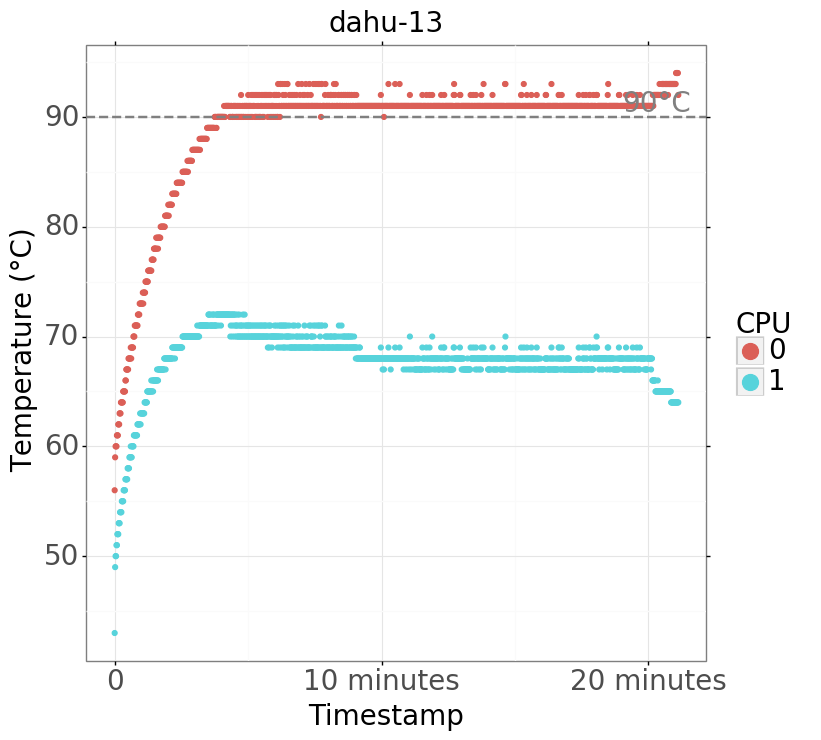

<ggplot: (-9223363272571383573)>


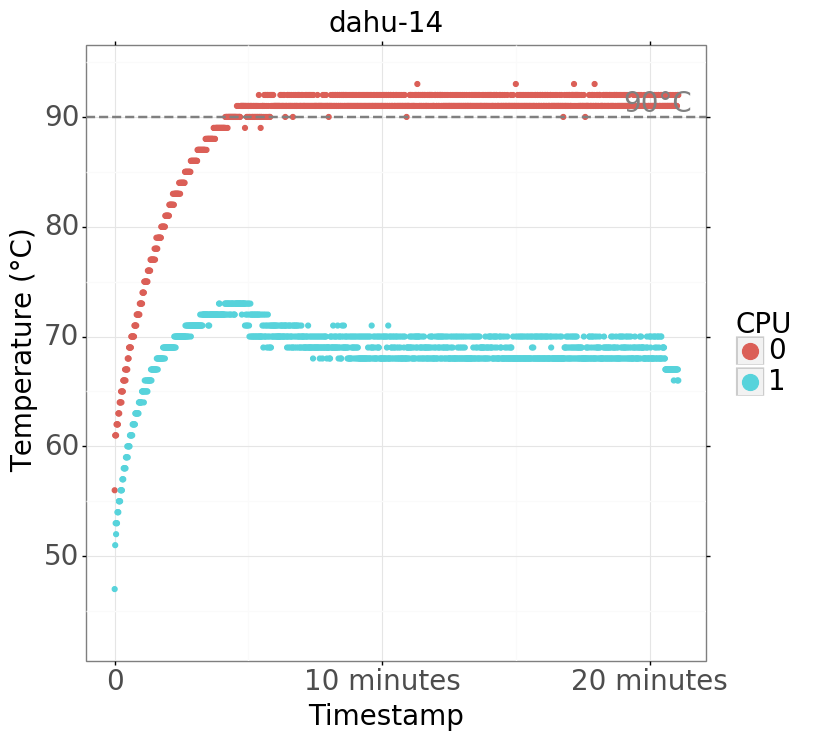

<ggplot: (-9223363272571410898)>


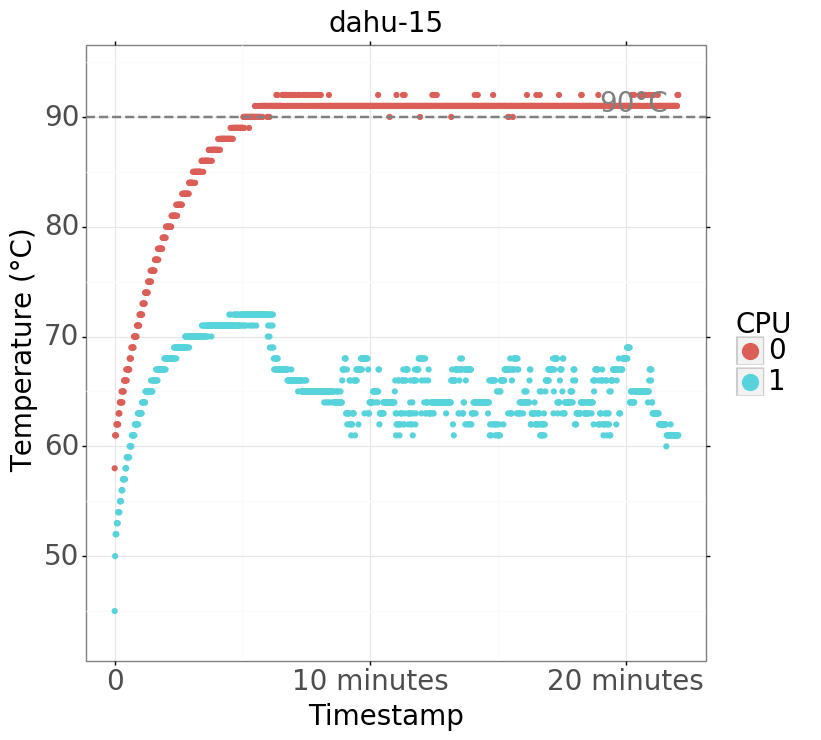

<ggplot: (-9223363272569850336)>


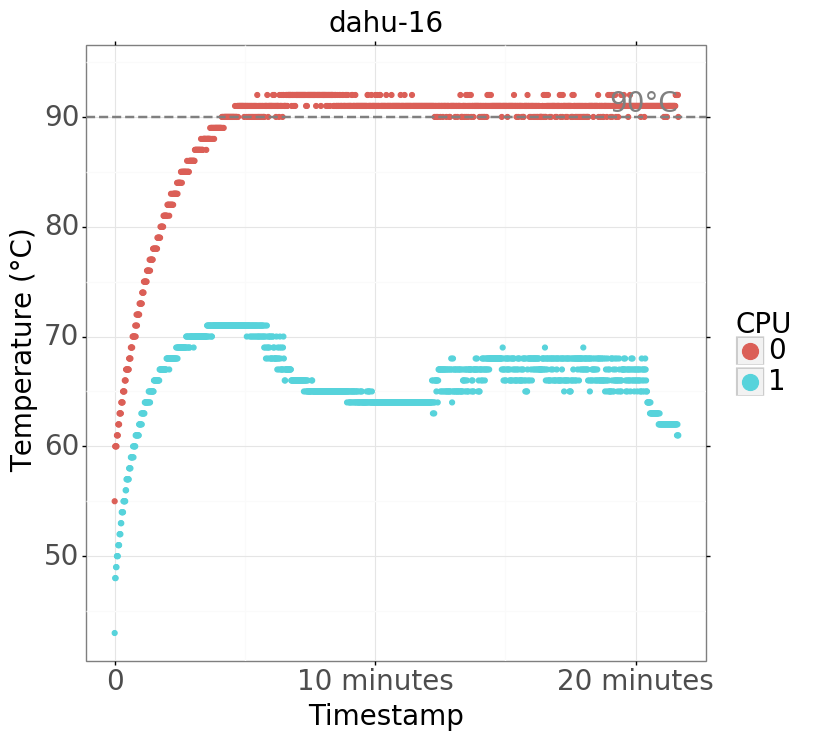

<ggplot: (-9223363272569896795)>


In [7]:
temp['cpu'] = temp['sensor_id']
generic_plot(temp, y='temperature', y_label='Temperature (°C)', shape=geom_point(), hline=(90, '°C'))

### Frequency

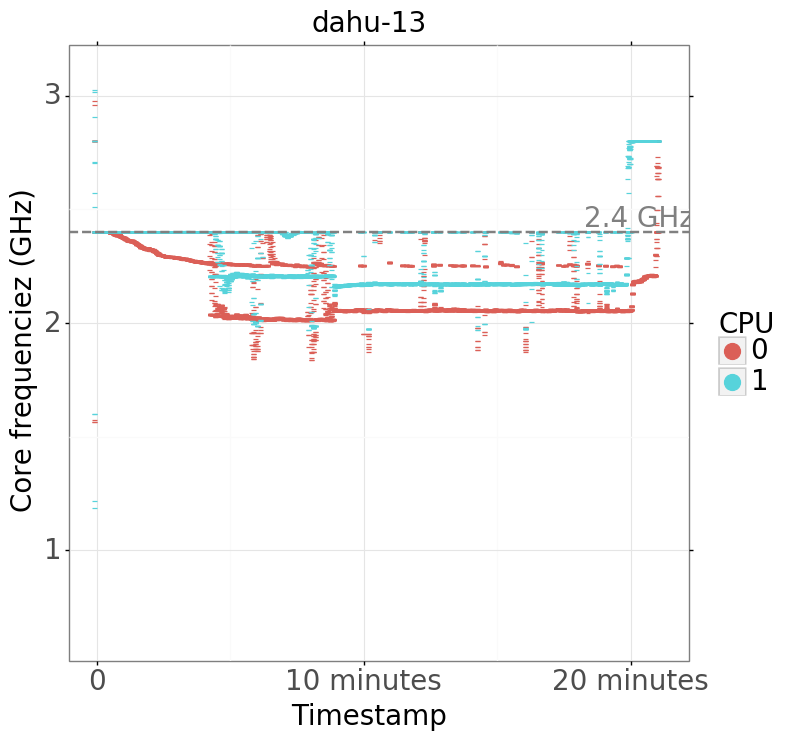

<ggplot: (-9223363272570043865)>


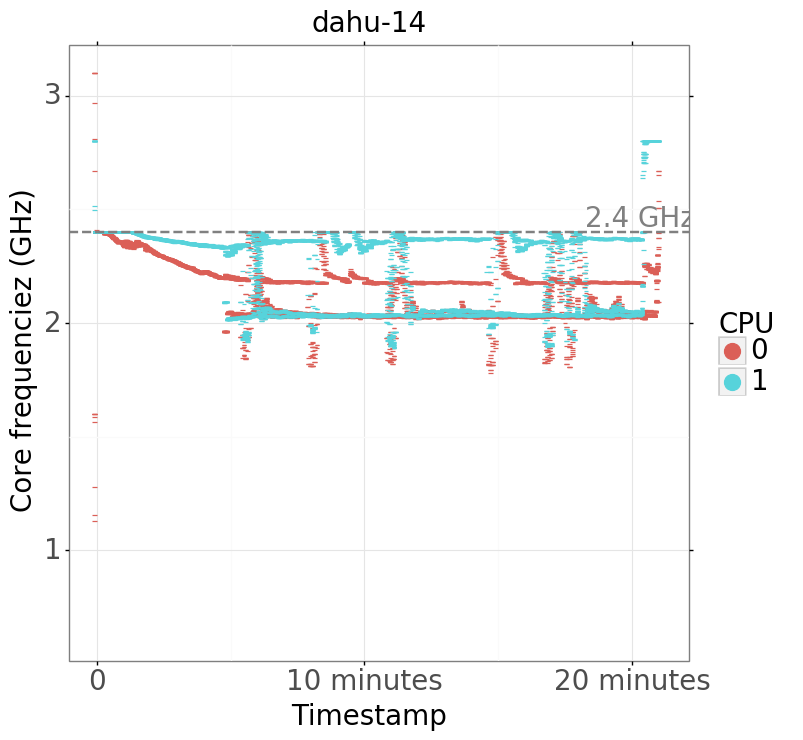

<ggplot: (8764284219996)>


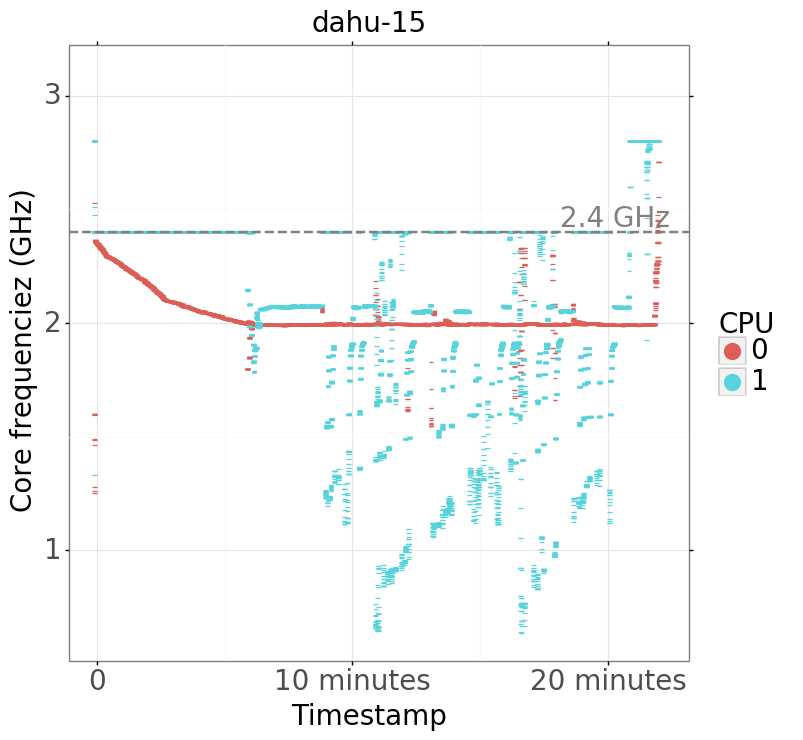

<ggplot: (8764284912725)>


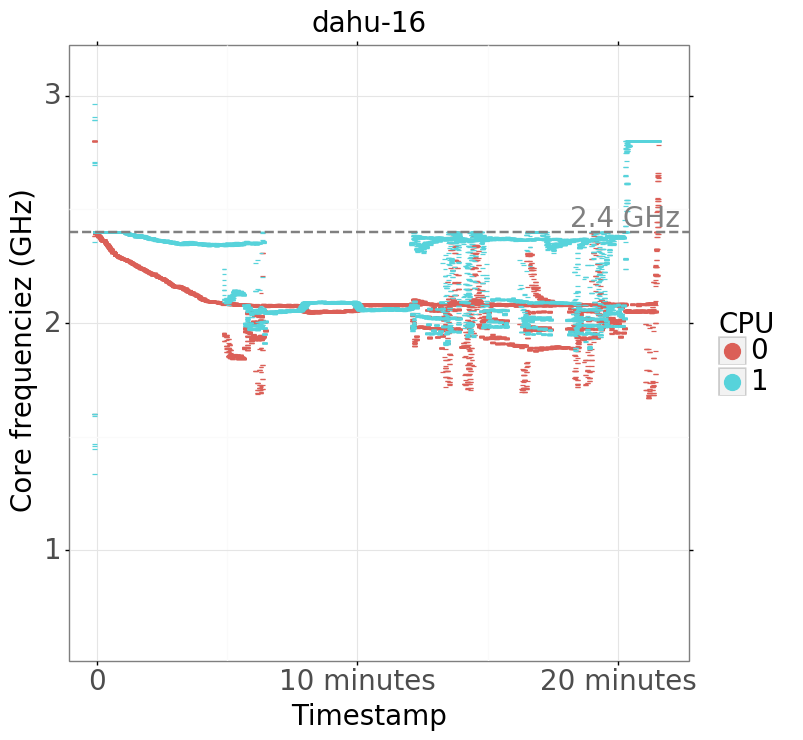

<ggplot: (8764283340352)>


In [8]:
freq['cpu'] = freq['core_id'] % 2

generic_plot(freq, y='frequency', y_label='Core frequenciez (GHz)', shape=geom_point(shape=0), hline=(2.4, ' GHz'))

### Performance

In [9]:
median_perf = int(round(perf['gflops'].median()))
median_perf

27

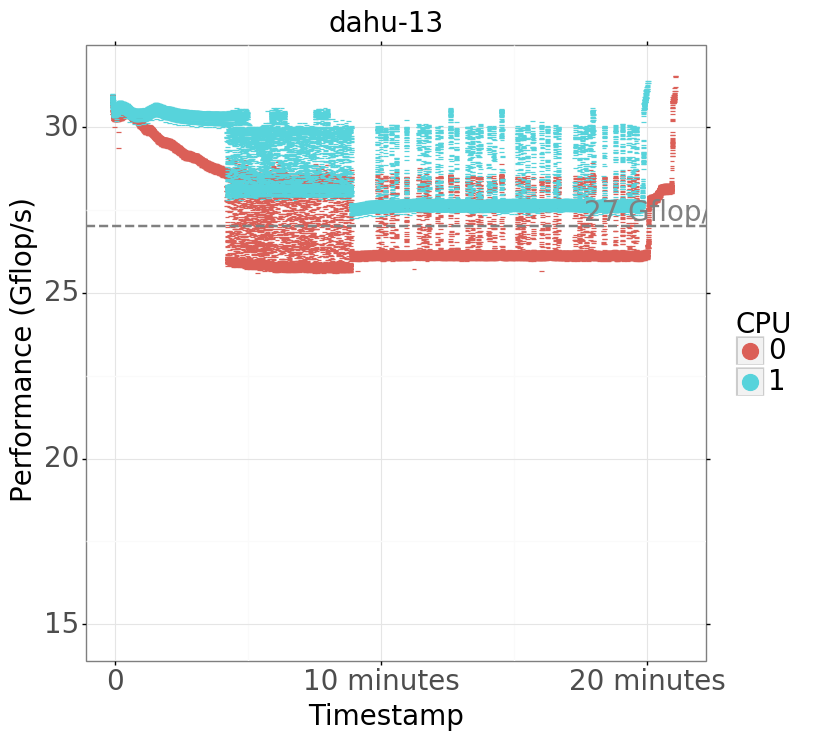

<ggplot: (8764283345770)>


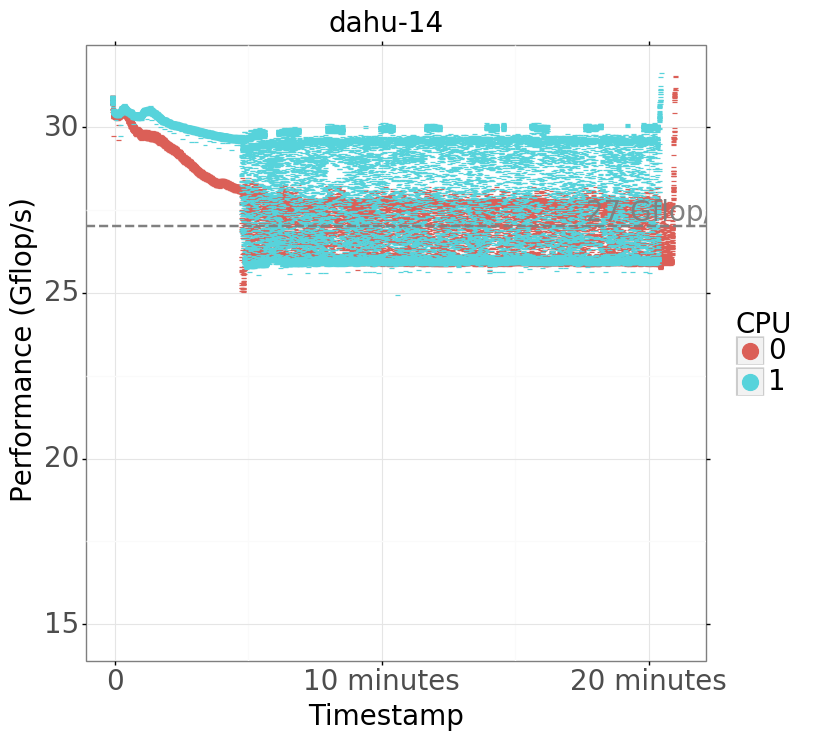

<ggplot: (8764284246178)>


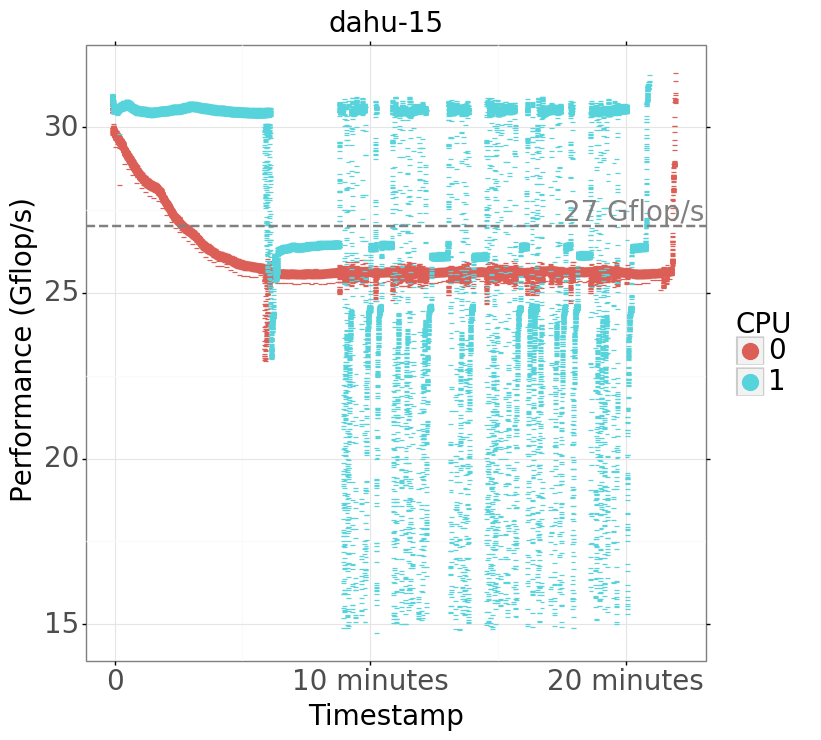

<ggplot: (8764284347796)>


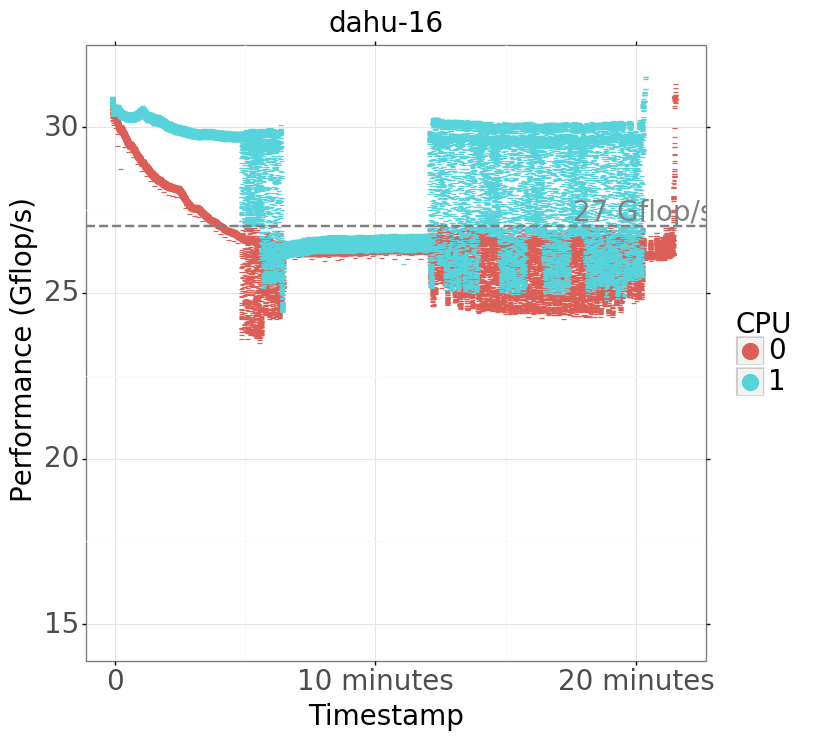

<ggplot: (8764284719052)>


In [10]:
perf['cpu'] = perf['core_id'] % 2

generic_plot(perf, y='gflops', y_label='Performance (Gflop/s)', shape=geom_point(shape=0), hline=(median_perf, ' Gflop/s'))